# 1- Importation des bibliothéques nécessaires :

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from PIL import Image as mpimg
import matplotlib.image as mpimg
drive.mount('/content/drive')
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
np.random.seed(232)
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import seaborn as sns
tf.random.set_seed(232)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2- Exploration des données :

# 2.1 Construction du chemin vers les répertoires du projet  :

In [39]:
cwd = os.getcwd()
main_file_path = os.path.join(cwd, 'Notebook.ipynb')


colab_notebooks_path = '/content/drive/My Drive/Colab Notebooks'


input_path = '/content/drive/My Drive/chest_xray'

train_path = os.path.join(input_path, 'train')
test_path = os.path.join(input_path, 'test')
val_path = os.path.join(input_path, 'val')

# 2.2 Visualisation de quelques images de l'ensemble de données :

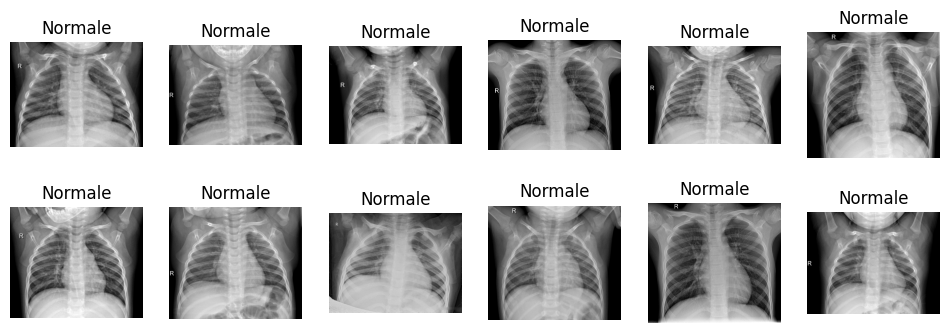

In [ ]:
import os
import matplotlib.pyplot as plt

input_path = '/content/drive/My Drive/chest_xray'

nows = 2
ncols = 6

train_path = input_path + '/train/NORMAL'


files = os.listdir(train_path)
rand_images = random.sample(files,nows*ncols)

fig = plt.gcf()
fig.set_size_inches(ncols*2, nows*2)


for i in range(len(rand_images)):
    sp = plt.subplot(nows, ncols, i + 1)
    plt.title("Normale")
    sp.axis('Off')

    img = mpimg.imread(train_path + '/' + rand_images[i])
    plt.imshow(img,cmap='gray')

plt.show()


# 2.3 Visualisation de quelques images anormales de l'ensemble de données :

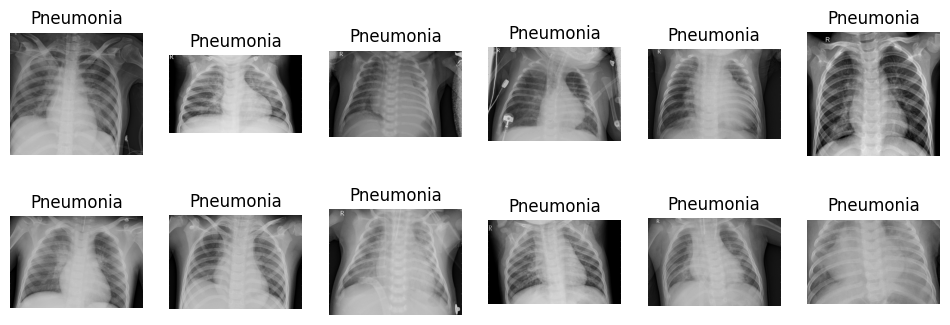

In [ ]:
nows = 2
ncols = 6

train_path = input_path + '/train/PNEUMONIA'


files = os.listdir(train_path)
rand_images = random.sample(files,nows*ncols)

fig = plt.gcf()
fig.set_size_inches(ncols*2, nows*2)


for i in range(len(rand_images)):
    sp = plt.subplot(nows, ncols, i + 1)
    plt.title("Pneumonia")
    sp.axis('Off')

    img = mpimg.imread(train_path + '/' + rand_images[i])
    plt.imshow(img,cmap='gray')

plt.show()

# 2.4- Voir les informations sur les répertoires :

In [ ]:
print("Le nombre d'images normales dans le répertoire train : ",len(os.listdir(input_path + "/train/NORMAL")))
print("Le nombre d'images anormales dans le répertoire train : ", len(os.listdir(input_path + "/train/PNEUMONIA")))

print("le nombre d'images normales dans le répertoire test : ",len(os.listdir(input_path + "/test/NORMAL")))
print("Le nombre d’images anormales dans le répertoire test : ",len(os.listdir(input_path + "/test/PNEUMONIA")))

print("Le nombre d'images normales dans le répertoire val : ",len(os.listdir(input_path + "/val/NORMAL")))
print("Le nombre d’images anormales dans le répertoire val : ",len(os.listdir(input_path + "/val/PNEUMONIA")))

Le nombre d'images normales dans le répertoire train :  1341
Le nombre d'images anormales dans le répertoire train :  3875
le nombre d'images normales dans le répertoire test :  234
Le nombre d’images anormales dans le répertoire test :  390
Le nombre d'images normales dans le répertoire val :  8
Le nombre d’images anormales dans le répertoire val :  8


# 2.5- Visualisation des données sous forme de graphiques :

In [ ]:
def plotData(dirPath):
    # Obtenez les sous-répertoires pour NORMAL et PNEUMONIA :
    normal_dir = os.path.join(dirPath, 'NORMAL')
    pneumonia_dir = os.path.join(dirPath, 'PNEUMONIA')

    # Vérifiez si les répertoires existent et contiennent des fichiers :
    if not os.path.exists(normal_dir) or not os.path.exists(pneumonia_dir):
        print("Error: Directories not found or empty.")
        return

    # Obtenez la liste de toutes les images :
    normal_cases = glob.glob(normal_dir + '/*.jpeg')
    pneumonia_cases = glob.glob(pneumonia_dir + '/*.jpeg')

    # Vérifiez s'il y a des images dans les deux répertoires :
    if not normal_cases or not pneumonia_cases:
        print("Error: No images found in one or both directories.")
        return

    # Une liste vide. Nous insérerons les données dans cette liste au format (img_path, label)
    data = []

    # Parcourez tous les cas normaux. L'étiquette de ces cas sera 0 :
    for img in normal_cases:
        data.append((img, 0))

    # Parcourez tous les cas de pneumonie. L'étiquette de ces cas sera 1
    for img in pneumonia_cases:
        data.append((img, 1))

    # Obtenez une trame de données pandas à partir des données que nous avons dans notre liste
    df = pd.DataFrame(data, columns=['image', 'label'])

    # Mélangez les données
    df = df.sample(frac=1.).reset_index(drop=True)

    # Obtenez les décomptes pour chaque classe
    cases_count = df['label'].value_counts()

    # Tracez les résultats
    plt.figure(figsize=(8,8))
    sns.barplot(x=cases_count.index, y=cases_count.values, palette=["gray", "orange"])
    plt.title('Number of cases', fontsize=12)
    plt.xlabel('Case type', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks(range(len(cases_count.index)), ['NORMAL', 'PNEUMONIA'])
    plt.show()

#2.6- voir le graphique des données d'entrainement :

<ipython-input-8-5a4f9b71c2c2>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cases_count.index, y=cases_count.values, palette=["gray", "orange"])


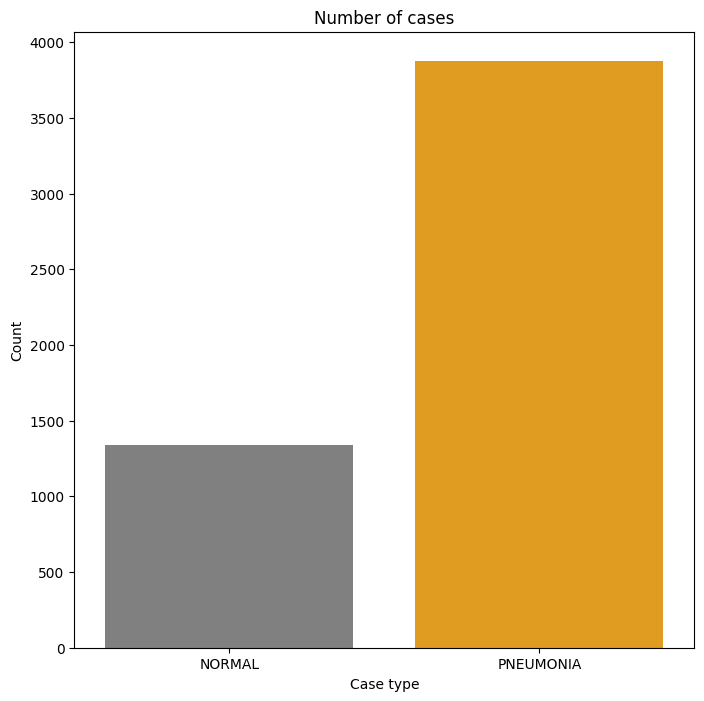

In [ ]:
# Appel de la fonction avec le chemin du répertoire d'entraînement :
input_path = '/content/drive/My Drive/chest_xray'
train_path = os.path.join(input_path, 'train')

plotData(train_path)

#2.7- voir le graphique des données de test :

<ipython-input-8-5a4f9b71c2c2>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cases_count.index, y=cases_count.values, palette=["gray", "orange"])


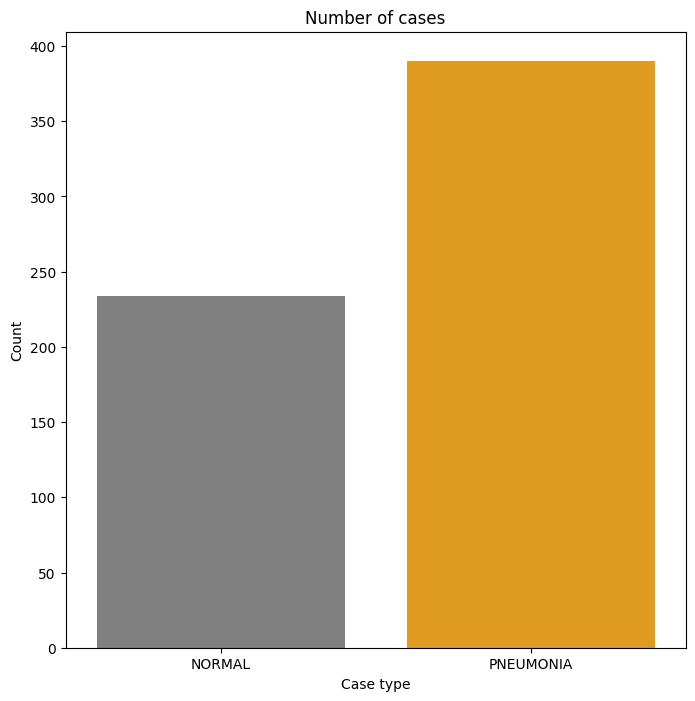

In [ ]:
plotData(test_path)

#2.8- voir le graphique des données de validation :

<ipython-input-8-5a4f9b71c2c2>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cases_count.index, y=cases_count.values, palette=["gray", "orange"])


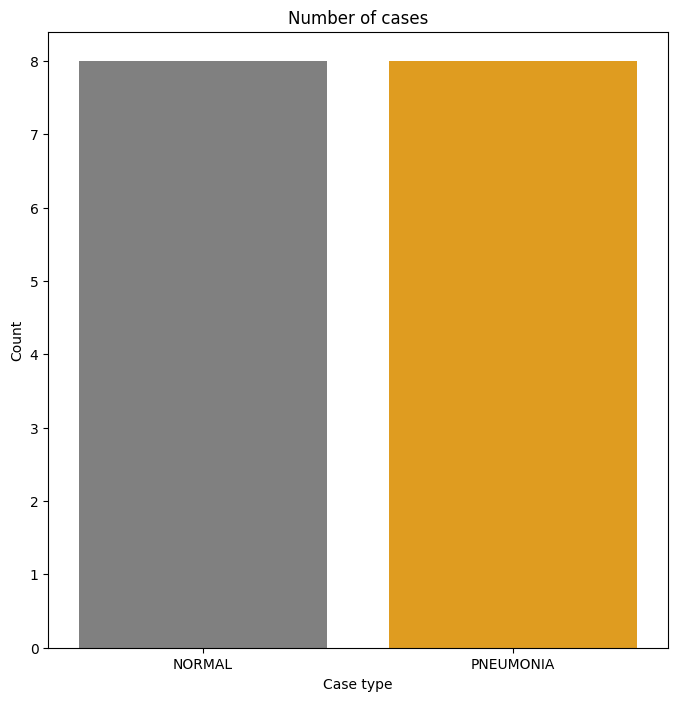

In [ ]:
plotData(val_path)

# 3- prétraitement des données :

In [ ]:
def process_data(img_dims, batch_size, train_path, test_path):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale=1./255, zoom_range=0.3, vertical_flip=True
        )   #
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
        test_path,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)


    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in os.listdir(test_path + cond):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

img_dims = 150
epochs = 10
batch_size = 32

train_path = '/content/drive/My Drive/chest_xray/train/'
test_path = '/content/drive/My Drive/chest_xray/test/'

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size, train_path, test_path)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 4- choix d'une architecture de réseau neuronal

#- 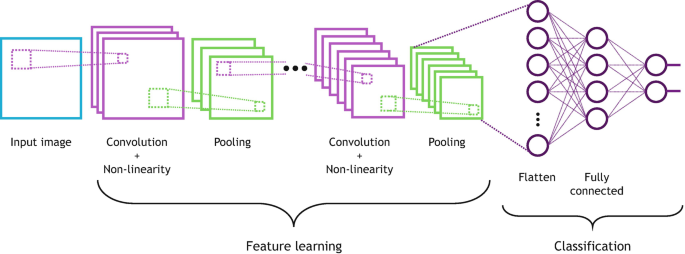

In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

# prémiere couche convolutionnelle :
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Seconde couche convolutionnelle :
x = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Troisiéme couche convolutionnelle
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# quatriéme couche convolutionnelle
x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Cinquiéme couche convolutionnelle
x = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# couche entiérement connectée
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# couche de sortie
output = Dense(1, activation='sigmoid')(x)

# 4.1- Création et compilation du modéle :


In [ ]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4.2- Affichage du résumé du modèle :

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 separable_conv2d_8 (Separa  (None, 75, 75, 32)        688       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_9 (Separa  (None, 75, 75, 32)        1344

In [ ]:
# Callbacks: les rappels
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/project/best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# 5- Entrainement du modéle :

In [31]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-31-1556081dfae9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 80s 488ms/step - loss: 0.1266 - accuracy: 0.9549 - val_loss: 0.2464 - val_accuracy: 0.9145 - lr: 1.9683e-08
Epoch 2/10
163/163 [==============================] - 79s 484ms/step - loss: 0.1208 - accuracy: 0.9580 - val_loss: 0.2446 - val_accuracy: 0.9145 - lr: 1.9683e-08
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9574
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.904900035602622e-09.
163/163 [==============================] - 79s 486ms/step - loss: 0.1146 - accuracy: 0.9574 - val_loss: 0.2452 - val_accuracy: 0.9145 - lr: 1.9683e-08
Epoch 4/10
163/163 [==============================] - 79s 487ms/step - loss: 0.1205 - accuracy: 0.9597 - val_loss: 0.2450 - val_accuracy: 0.9161 - lr: 5.9049e-09
Epoch 5/10
163/163 [==============================] - 79s 486ms/step - loss: 0.1165 - accuracy: 0.9590 - val_loss: 0.2486 - val_accuracy: 0.9128 - lr: 5.9049e-09
Epoch 6/10
163/163 [=========

# 6- évaluation du modéle :

In [33]:
# Charger les poids optimaux
model.load_weights('/content/drive/My Drive/project/best_weights.hdf5')

# Évaluation sur l'ensemble de test
evaluation = model.evaluate(test_data, test_labels)

# Afficher les résultats de l'évaluation
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

20/20 [==============================] - 0s 6ms/step - loss: 0.2208 - accuracy: 0.9295
Loss: 0.22079777717590332
Accuracy: 0.9294871687889099


# 7- Visualisation des résultats :

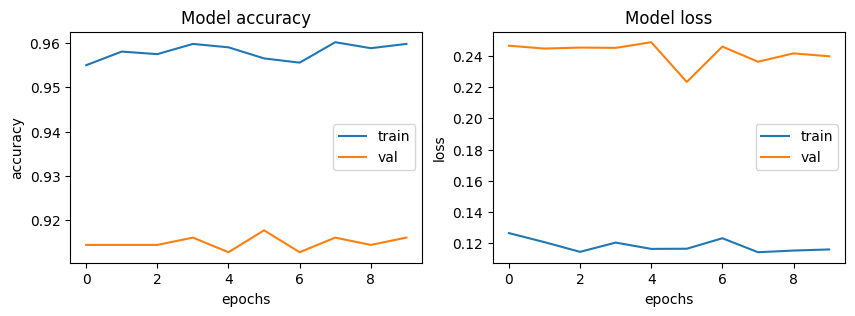

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 8- Prédiction et calcul de la précision, rappel et F1-score puis affichage de la matrice de confusion :

20/20 [==============================] - 0s 5ms/step
CONFUSION MATRIX ------------------
[[205  29]
 [ 15 375]]


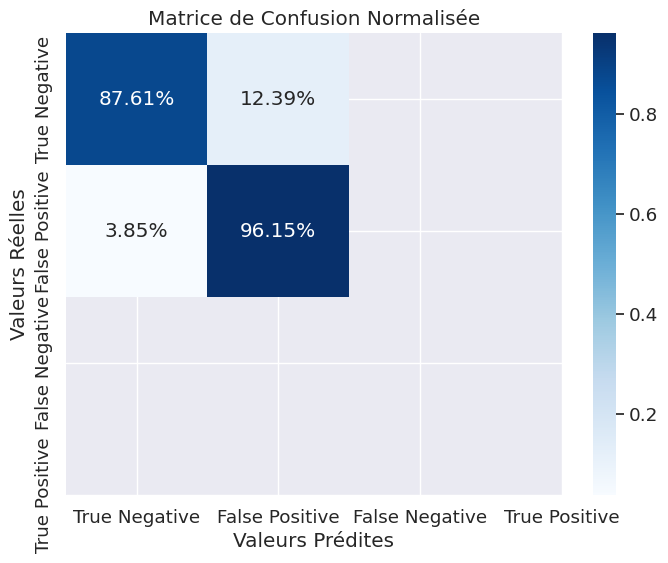

Sensibilité: 96.1538
Spécificité: 87.6068

TEST METRICS ----------------------
Exactitude: 92.94871794871796%
Précision: 92.82178217821783%
Rappel: 96.15384615384616%
Score F1: 94.45843828715367

TRAIN METRIC ----------------------
20/20 [==============================] - 0s 5ms/step
CONFUSION MATRIX ------------------
[[205  29]
 [ 15 375]]


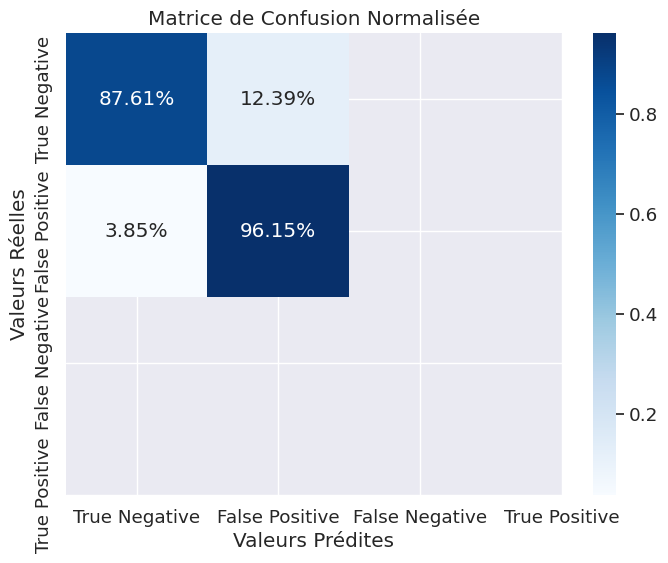

Sensibilité: 96.1538
Spécificité: 87.6068

TEST METRICS ----------------------
Exactitude: 92.94871794871796%
Précision: 92.82178217821783%
Rappel: 96.15384615384616%
Score F1: 94.45843828715367

TRAIN METRIC ----------------------


In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des prédictions du modèle sur les données de test
preds = model.predict(test_data)

# Calcul de l'exactitude (accuracy)
acc = accuracy_score(test_labels, np.round(preds)) * 100

# Calcul de la matrice de confusion
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

# Définition des étiquettes des axes
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Conversion de la matrice en pourcentages pour une meilleure visualisation
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Configuration de la figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajuster la taille de la police
sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Ajout de titres et d'étiquettes
plt.title('Matrice de Confusion Normalisée')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.show()

# Calcul de la sensibilité (recall)
sensitivity = recall_score(test_labels, np.round(preds)) * 100

# Calcul de la spécificité
specificity = (tn / (tn + fp)) * 100

print("Sensibilité: {:.4f}".format(sensitivity))
print("Spécificité: {:.4f}".format(specificity))

print('\nTEST METRICS ----------------------')

# Calcul de la précision
precision = precision_score(test_labels, np.round(preds)) * 100

# Calcul du rappel (recall)
recall = tp / (tp + fn) * 100

# Calcul du score F1
f1_score = 2 * precision * recall / (precision + recall)

print('Exactitude: {}%'.format(acc))
print('Précision: {}%'.format(precision))
print('Rappel: {}%'.format(recall))
print('Score F1: {}'.format(f1_score))

print('\nTRAIN METRIC ----------------------')

# 9- le rapport de classification :

In [37]:
from sklearn.metrics import classification_report

# Génération du rapport de classification
class_report = classification_report(test_labels, np.round(preds), target_names=['NORMAL', 'PNEUMONIA'])

# Affichage du rapport de classification
print("Rapport de Classification :\n", class_report)

Rapport de Classification :
               precision    recall  f1-score   support

      NORMAL       0.93      0.88      0.90       234
   PNEUMONIA       0.93      0.96      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



# 10- Sauvegarde du modéle :

In [38]:
# Définir le chemin de sauvegarde du modèle
model_save_path = '/content/drive/My Drive/test.h5'

# Sauvegarder le modèle
model.save(model_save_path)

print("Le modèle a été sauvegardé avec succès à l'emplacement :", model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Le modèle a été sauvegardé avec succès à l'emplacement : /content/drive/My Drive/test.h5
